# Network Visualization
The idea is to feed noise into the image and gradient descend the image instead of the model.

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from orange_peels import OrangePeelsDataset

In [2]:
IMG_DIR = "./data_orange_peels/"
TRAIN_PROPORTION = 0.8
BATCH_SIZE = 32
NUM_EPOCHS = 20
LR = 0.001
IMAGE_SIZE = (3024, 4032)
SIZE_MODIFIER = 0.0625
RESNET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
RESNET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

In [3]:
transform = transforms.Compose([
    transforms.Resize((int(SIZE_MODIFIER*IMAGE_SIZE[0]), int(SIZE_MODIFIER*IMAGE_SIZE[1]))),
    transforms.Normalize(mean = RESNET_MEAN, std = RESNET_STD),
])

inverse_transform = transforms.Compose([
    transforms.Normalize(mean = [0., 0., 0.,], std = [1/sd for sd in RESNET_STD]),
    transforms.Normalize(mean = [-m for m in RESNET_MEAN], std = [1., 1., 1.]),
])

data = OrangePeelsDataset(IMG_DIR, class_size = 80, transform = transform)

In [16]:
def jitter(X, ox, oy):
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def deprocess(img, should_rescale=True):
    transform = transforms.Compose([
        transforms.Lambda(lambda x: x[0]),
        transforms.Normalize(mean=[0, 0, 0], std=(1.0 / RESNET_STD).tolist()),
        transforms.Normalize(mean=(-RESNET_MEAN).tolist(), std=[1, 1, 1]),
        transforms.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        transforms.ToPILImage(),
    ])
    return transform(img)

def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-5)
    learning_rate = kwargs.pop('learning_rate', 10)
    num_iterations = kwargs.pop('num_iterations', 400)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and also wrap it in
    # a PyTorch Variable.
    img = torch.randn(1, 3, int(SIZE_MODIFIER*IMAGE_SIZE[0]), int(SIZE_MODIFIER*IMAGE_SIZE[1])).mul_(1.0).type(dtype)
    img_var = Variable(img, requires_grad=True)

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.copy_(jitter(img, ox, oy))

        ########################################################################
        # TODO: Use the model to compute the gradient of the score for the     #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. Don't forget the #
        # L2 regularization term!                                              #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        score = model(img_var)
        target_y_score = score[:, target_y] - (l2_reg * torch.square(torch.norm(img)))
        target_y_score.backward()
        img_var.data += learning_rate * img_var.grad.data
        img_var.grad.data.zero_()
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        
        # Undo the random jitter
        img.copy_(jitter(img, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-RESNET_MEAN[c] / RESNET_STD[c])
            hi = float((1.0 - RESNET_MEAN[c]) / RESNET_STD[c])
            img[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img, sigma=0.5)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.clone().cpu()))
            class_name = data.decoder[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.cpu())

def compute_saliency_map(X, y, model, device):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Wrap the input tensors in Variables
    X_var = Variable(X, requires_grad=True)
    y_var = Variable(y)
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores, and then compute the gradients with a backward pass.               #
    ##############################################################################
    y_predict = model(X_var) #N * C
    scores = y_predict.gather(1, y_var.view(-1, 1)).squeeze()
    scores.backward(torch.ones(scores.shape[0]).to(device))
    saliency = torch.max(X_var.grad.data.abs(), dim=1)[0]
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [40]:
# load model
# model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained = True).to(device).eval()
# model = torch.hub.load("pytorch/vision:v0.10.0", "vgg19", pretrained=True).to(device).eval()
model = torch.load("0_765_model.pt").to(device).eval()
for param in model.parameters():
    param.requires_grad = False

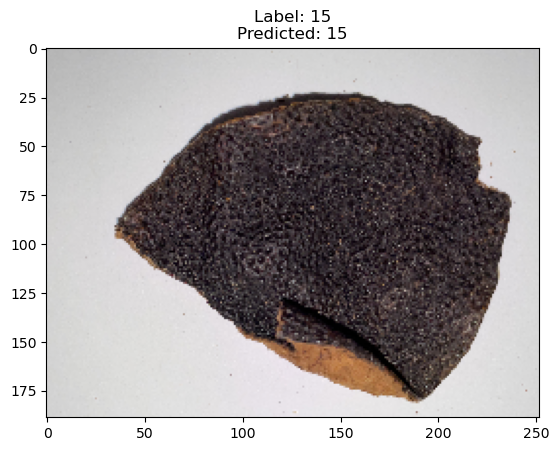

In [19]:
rand_idx = random.randint(0, len(data))
image = inverse_transform(data[rand_idx][0]).numpy().astype(np.int32).transpose(1, 2, 0)
guess = model(data[rand_idx][0].unsqueeze(0).to(device)).argmax().item()
plt.imshow(image)
plt.title(f"Label: {data.decoder[data[rand_idx][1]]}\nPredicted: {data.decoder[guess]}")
plt.show()

In [43]:
images = []
labels = []
for _ in range(3):
    idx = random.randint(0, len(data))
    images.append(data[idx][0])
    labels.append(data[idx][1])

In [44]:
X = torch.cat([img.unsqueeze(0) for img in images], dim=0).to(device)
y = torch.LongTensor(labels).to(device)
print(X.shape, y.shape)
saliency = compute_saliency_map(X, y, model, device)

torch.Size([3, 3, 189, 252]) torch.Size([3])


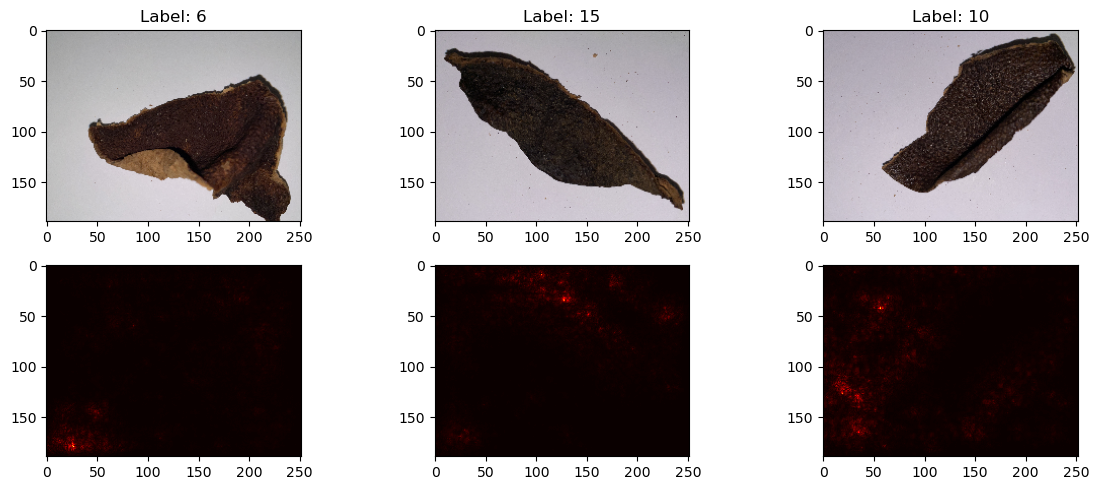

In [45]:
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(inverse_transform(images[i]).numpy().astype(np.int32).transpose(1, 2, 0))
    plt.title(f"Label: {data.decoder[labels[i]]}")
    plt.subplot(2, 3, 3+i+1)
    plt.imshow(saliency[i].cpu().numpy(), cmap=plt.cm.hot)
    plt.gcf().set_size_inches(12, 5)
plt.tight_layout()
plt.show()

In [42]:
loader = DataLoader(data, batch_size = BATCH_SIZE, shuffle = True)

In [55]:
predictions = torch.tensor([], dtype=torch.long).to(device)
actual = torch.tensor([], dtype=torch.long).to(device)
incorrect_images = []
with torch.no_grad():
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        output = model(images)
        _, predicted = torch.max(output.data, 1)

        predictions = torch.cat((predictions, predicted))
        actual = torch.cat((actual, labels))

        # save image where prediction is wrong
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                incorrect_images.append((images[i], labels[i], predicted[i]))

In [133]:
d = {}
for incorrect in incorrect_images:
    if incorrect[1].item() not in d:
        d[incorrect[1].item()] = 0
    d[incorrect[1].item()] += 1

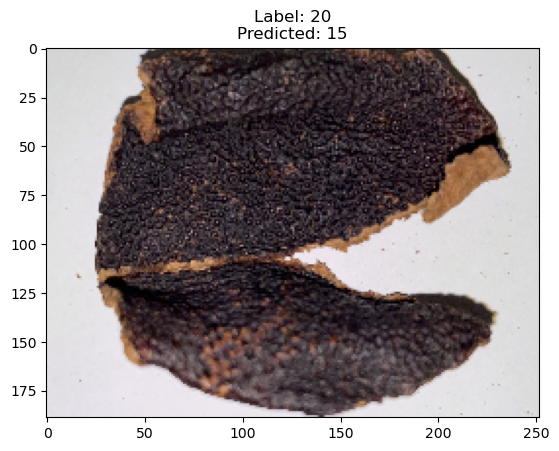

In [178]:
plt.imshow(inverse_transform(incorrect_images[0][0]).cpu().numpy().astype(np.int32).transpose(1, 2, 0))
plt.title(f"Label: {data.decoder[incorrect_images[idx][1].item()]}\nPredicted: {data.decoder[incorrect_images[idx][2].item()]}")